# Tutorial: Making a plot of orbits and equitorial crossing times

This tutorial shows how to make an equitorial crossing plot for all current and past NOAA, NASA, and EUMETSAT LEO satellites. The satellite equatorial crossing time is the local solar time when a satellite crosses the equator during its orbit. Each day, most places on earth get at least two overpasses; polar regions have the best coverage. It's important to maintain a long term record of polar orbiting satellites to ensure that weather models are correctly tuned to weather trends.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from datetime import datetime, date

First, we need to inspect the orbits files, which are stored in the 'data/' subdirectory (originally obtained from the [NOAA Calibration Center](https://ncc.nesdis.noaa.gov/NOAA-20/data/LECT/2023-03/index.php)). The file names follow the format "LECT_<SATNAME>.txt". Pick a random file and open it up! You will see that there are 12 columns in each files, the first 6 columns are the local times (Mon, Day, Year, Hour, Minutes, Second), the seventh column is the equator crossing longitude, and the remaininng columns are equator crossing UTC time (Mon, Day, Year, Hour, Minutes, Second). We will want to convert these the times from local time to UTC so that the satellites are comparable with each other.

Since the data does not have a header, we will have to make our own. We could manually write out the column names as a list, but since there's some redundancy, I chose to use for loops to automate the process.

In [3]:
columns=[]
times = ['Mon', 'Day', 'Year', 'Hour', 'Minutes', 'Second']
for time in times:
    columns.append(time+'_LT')
    
columns.append('Longitude')

for time in times:
    columns.append(time+'_UTC')

Next, lets search for the filenames in the data folder. We'll use the glob command to return all the files.

In [4]:
# Search for all orbit files
files = glob.glob("data/*.txt")

Before we can make a plot, we will need to "clean" up the data. 

Below we'll make two helper function to clean up our plots. The first (concat_dates) reads in the dates and times and converts to the datetime format. This will help make a time series plot.

The second function (get_satname) will extract the name of the satellite from the data filenames.

In [5]:
# Define functions to help format data
def concat_dates(tmp, node):
    dates = []
    for index, row in tmp.iterrows():
        row_date=datetime.datetime(row['Year_'+node], row['Mon_'+node], row['Day_'+node])
        dates.append(row_date)
    return dates

def get_satname(file):
    return  file.split("_")[1].split(".")[0]
    

In the next block, we'll use read_csv to open the file. We are going to read each file into a temporary variable (tmp), reformat the satellite name, convert the UTC dates to the datetime format (using the helper functions defined above), and convert the crossing time to a fraction of an hour. We'dd drop the original columns to clean up our dataset and the concatenate (previously, the syntax was append in Pandas, but this is now deprecated) the temporary dataframe (tmp) with the longer dataframe.

In [6]:
# Empty data frame to append to
df = pd.DataFrame()

for file in files:
    tmp = pd.read_csv(file, names=columns, sep='\\s+')
    tmp['sat_name'] = get_satname(file)
    tmp['obs_date'] = concat_dates(tmp, 'UTC')
    tmp['crossing_hour_LT'] = tmp['Hour_LT']+tmp['Minutes_LT']/60
    tmp['crossing_hour_UTC'] = tmp['Hour_UTC']+tmp['Minutes_UTC']/60

    # Keep only necessary columns
    tmp = tmp[['sat_name','crossing_hour_LT','crossing_hour_UTC','obs_date']]
    df = pd.concat([df, tmp])

Let's make a basic plot! We are setting the index to be the obs_date (because we want the y-axis to be ascend by date) and sat_name to be the group so that we can color code the orbits.

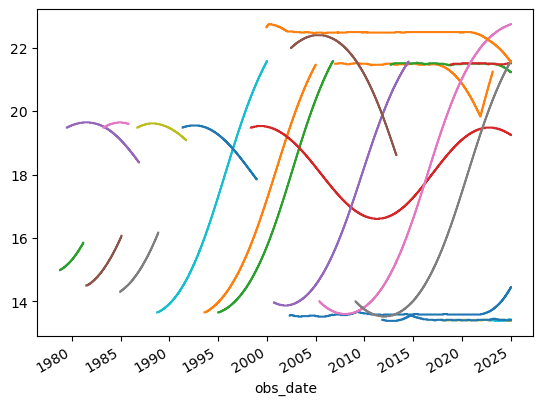

In [7]:
df2 = df.set_index('obs_date').groupby('sat_name')
df2['crossing_hour_UTC'].plot()
plt.show()

The earliest satellites show a drift over time in their afternoon (ascending) overpasses. 

The plot above is a good start - but there are some problems. It would be nice to see the labels!

 The keyword arguements (plot_kwargs) help make the plot more readable, feel free to tweak these to explore how they impact the final plot. Next, we add labels to the x- and y- axis, as well as the legend. This makes the figure publication ready!

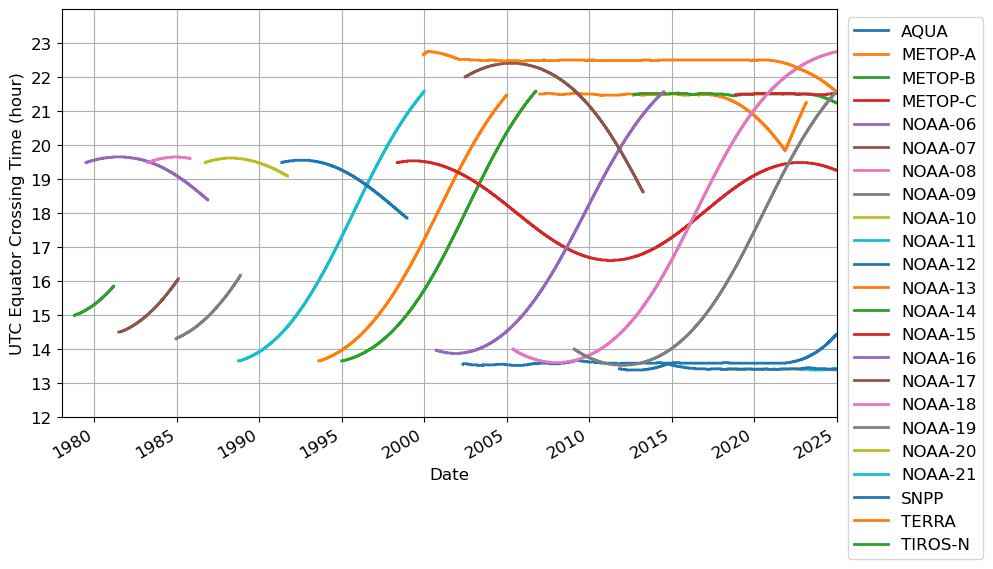

In [10]:
df2 = df.set_index('obs_date').groupby('sat_name')

# Plot options
plot_kwargs={
    'xlim' : [date(1978, 1, 1), date(2025, 1, 1)],
    'ylim' : [12, 24],
    'yticks' : np.arange(0,24),
    'fontsize': 12,
    'figsize' : (10, 6),
    'legend': True,
    'grid': True,
    'lw' : 2}


# Make base plot
df2['crossing_hour_UTC'].plot(**plot_kwargs)

ax = plt.gca()
ax.legend(loc='upper right', prop={'size': 12}, bbox_to_anchor=(1.2,1))
ax.set_ylabel("UTC Equator Crossing Time (hour)", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

plt.show()

I hope you found this tutorial helpful!